In [1]:
%matplotlib inline
import seaborn as sns; 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib import gridspec
import scipy
style.use('fast')
from datetime import datetime
from io import StringIO
import re
import numpy as np
from datetime import datetime
import os


In [2]:
sns.set_style('ticks',{'legend.frameon':True} )
sns.set_palette('colorblind')
FIG_SIZE = (12, 3)
font = {'family' : 'Times New Roman',
        'weight' : 'bold',
        'size'   : 22}
plt.rc('font', **font)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['text.usetex'] = True

plt.rcParams['xtick.labelsize'] = 22
plt.rcParams['ytick.labelsize'] = 22
plt.rcParams['axes.labelsize']= 22
flatui = [sns.xkcd_rgb["medium green"], "orange", sns.xkcd_rgb["medium purple"], "#e74c3c", "#34495e", "#2ecc71"]


In [4]:
# Cliff's Delta
from __future__ import division
 
def cliffsDelta(lst1,lst2,
                dull = [0.147, # small
                        0.33,  # medium
                        0.474 # large
                        ][0] ): 
  "Returns true if there are more than 'dull' differences"
  m, n = len(lst1), len(lst2)
  lst2 = sorted(lst2)
  j = more = less = 0
  for repeats,x in runs(sorted(lst1)):
    while j <= (n - 1) and lst2[j] <  x: 
      j += 1
    more += j*repeats
    while j <= (n - 1) and lst2[j] == x: 
      j += 1
    less += (n - j)*repeats
  d= (more - less) / (m*n)
  f=abs(d)  > dull
  print("d="+str(d))#+' '+str(f))
  return abs(d)  > dull
   
def runs(lst):
  "Iterator, chunks repeated values"
  for j,two in enumerate(lst):
    if j == 0:
      one,i = two,0
    if one!=two:
      yield j - i,one
      i = j
    one=two
  yield j - i + 1,two
  
def _cliffsDelta():
  "demo function"
  lst1=[1,2,3,4,5,6,7]
  for r in [1.01,1.1,1.21, 1.5, 2]:
    lst2=map(lambda x: x*r,lst1)

# RQ0
# LOAD TRACKED PACKAGES AND THEIR SOURCES

In [3]:
# Load used packages ( prepared)
official_sources=pd.read_csv('../../docker/csv/used/official_sources.csv', sep=';', dtype=object, index_col=None,  error_bad_lines=False)
community_sources=pd.read_csv('../../docker/csv/used/community_sources.csv', sep=';', dtype=object, index_col=None,  error_bad_lines=False)
official_sources['type']="Official"
community_sources['type']="Community"

In [8]:
len(official_sources[['name','package','version']].drop_duplicates())

561645

In [9]:
official_sources.groupby('name').count()[['package']].package.median()

190.0

In [10]:
community_sources.groupby('name').count()[['package']].package.median()

261.0

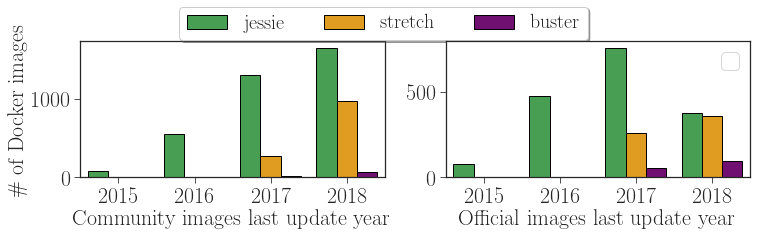

In [108]:
figure, axes = plt.subplots(1, 2, sharex=True, sharey=False)
figure.set_size_inches(12,2.5)

df_tmp=(official_sources.
        assign(year= lambda d: d['created'].apply(lambda x: x.split('-')[0])
              ))

df_tmp=(df_tmp.
        groupby(['name','debian','year']).
        count().
        groupby(['debian','year']).
        count().
        reset_index()
       )

ax = sns.barplot(
    y="package", x='year', hue='debian', data=df_tmp, 
    palette=flatui, linewidth=1,  ax=axes[1], hue_order=['jessie','stretch','buster'])

ax.legend('')
for patch in ax.patches:
    patch.set_edgecolor('black')
ax.set_xlabel("Official images last update year")
ax.set_ylabel("")

    
df_tmp=(community_sources.
        assign(year= lambda d: d['created'].apply(lambda x: x.split('-')[0])
              ))

df_tmp=(df_tmp.
        groupby(['name','debian','year']).
        count().
        groupby(['debian','year']).
        count().
        reset_index()
       )
ax = sns.barplot(
    y="package", x='year', hue='debian', data=df_tmp, 
    palette=flatui, linewidth=1,  ax=axes[0], hue_order=['jessie','stretch','buster'])

ax.set_xlabel("Community images last update year")
ax.set_ylabel('\# of Docker images')
for patch in ax.patches:
    patch.set_edgecolor('black')
ax.legend(loc='upper right', bbox_to_anchor=(1.7, 1.33), ncol=3, fontsize=20, fancybox=True, shadow=True)


In [4]:
sources_all=pd.concat([community_sources,official_sources])
sources_all.head(2)

,package,version,name,debian,created,date,source,source_version,release_snapshot,inSecurity,release_repo,type
0,abiword,3.0.0-8+b1,fuerst:etherpad-docker,jessie,2018-03-22,20150108,abiword,3.0.0-8,jessie,False,jessie,Community
1,abiword,3.0.2-2,ngiger:jubula_runner,stretch,2017-10-09,20161210,abiword,3.0.2-2,stretch,False,stretch,Community


Text(1.05,1.05,'First seen in: ')

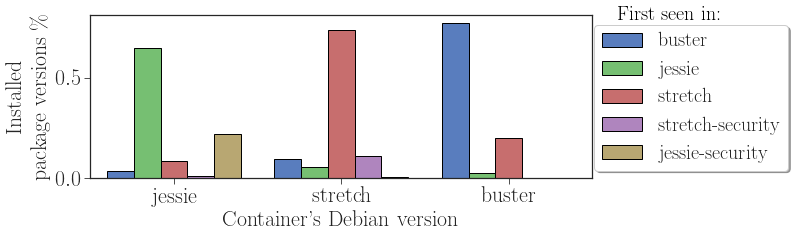

In [8]:
# Plot where UNIQUE packages were first seen 

first_seen_used=(sources_all.
                 #query('created>"2018"').
                 groupby(['debian','release_repo','package','version']).
                 count())
first_seen_used=first_seen_used.groupby(['debian','release_repo']).count()
first_seen_used.reset_index(inplace=True)
first_seen_used['usage']=first_seen_used[['debian','name']].apply(lambda x:
                                                                    x['name']/max(first_seen_used.query('debian=="buster"')['name'].cumsum()) if x['debian']=='buster'
                                                                    else x['name']/max(first_seen_used.query('debian=="stretch"')['name'].cumsum()) if x['debian']=='stretch'
                                                                    else x['name']/max(first_seen_used.query('debian=="jessie"')['name'].cumsum()),
                                                                    axis=1)

order=['jessie','stretch','buster']


ax = sns.barplot(x="debian", y="usage", 
                 hue="release_repo", data=first_seen_used, 
                 palette="muted", linewidth=1, order=order)
ax.figure.set_size_inches(9,3)
ax.set_xlabel("Container's Debian version")
ax.set_ylabel('Installed \n package versions \%')
for patch in ax.patches:
    patch.set_edgecolor('black')
ax.legend(loc='upper right', bbox_to_anchor=(1.41, 1), fontsize=20, fancybox=True, shadow=True)
ax.text(1.05, 1.05, 'First seen in: ', transform=ax.transAxes, fontsize=20,
        verticalalignment='top', color='black')

# RQ1:
# Let's see if packages are outdated


In [12]:
debian_packages_order=pd.read_csv('../../docker/csv/used/debian_packages_order_4mai.csv', sep=";")

In [13]:
# Create the dataframe with outdates
df=debian_packages_order.loc[:,['package','version','version_order','last_order','latest']]

# Official
outdate_official=official_sources.set_index(['package','version']).merge(
    df.set_index(['package','version']),
    left_index=True, 
    right_index=True, 
    how='outer').dropna().reset_index()

outdate_official['outdate']=outdate_official['last_order']-outdate_official['version_order']
outdate_official['isOutdate']=outdate_official['outdate'].apply(lambda x: 'Outdated' if x!=0
                                                                 else 'Up-to-date')
# Community
outdate_community=community_sources.set_index(['package','version']).merge(
    df.set_index(['package','version']),
    left_index=True, 
    right_index=True, 
    how='outer').dropna().reset_index()

outdate_community['outdate']=outdate_community['last_order']-outdate_community['version_order']
outdate_community['isOutdate']=outdate_community['outdate'].apply(lambda x: 'Outdated' if x!=0
                                                                 else 'Up-to-date')
print('Outdated Community packages:', len(outdate_community))
print('Outdated Official packages:', len(outdate_official))

Outdated Community packages: 1378241
Outdated Official packages: 561645


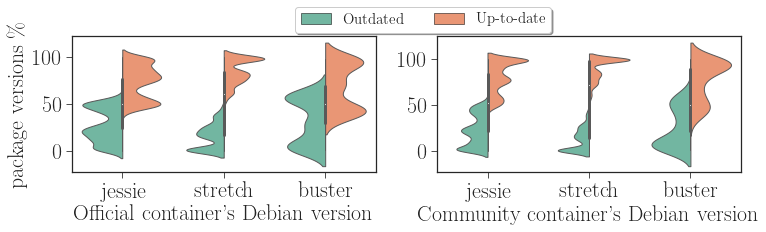

In [78]:
# Plot how many are out of date per CONTAINER
dff=pd.concat([outdate_official,outdate_community])#.query('created>"2018"')
dff=dff.groupby(['package','version','name','debian','type','isOutdate']).count().loc[:,[]].reset_index()

dff1=dff.groupby(['name','debian','type','isOutdate']).count().loc[:,['package']].reset_index()
dff2=dff.groupby(['name','debian','type']).count().reset_index().loc[:,['name','version']]

dff=(dff1.
     merge(
         dff2,
         left_on='name',
         right_on='name',
         how='left').
     assign(installed=lambda d: (d['package']*100/d['version']).apply(int)).
     drop(['version','package'], axis=1)
    )

fig, axes = plt.subplots(1, 2, sharex=False, sharey=False)

order=['jessie','stretch','buster']

for index, type in enumerate(['Official', 'Community']):
    data=dff.query('type=="'+type+'"')
    ax = sns.violinplot(x="debian", y="installed", hue="isOutdate",
                     data=data, palette="Set2", order=order, hue_order=['Outdated','Up-to-date'], linewidth=1,
                    ax=axes[index], split=True)
    ax.figure.set_size_inches(12,2.5)
    ax.set_ylabel('package versions \%')
    for patch in ax.patches:
        patch.set_edgecolor('black')
    ax.legend('',bbox_to_anchor=(1.3, 1.3))
    ax.set_xlabel(type+" container's Debian version")
ax.set_ylabel('')
ax.legend(loc='upper right', bbox_to_anchor=(0.4, 1.27), ncol=3, fontsize=15, fancybox=True, shadow=True)


In [54]:
scipy.stats.normaltest(data.query('isOutdate=="Outdated"').installed)

NormaltestResult(statistic=947.4631257665186, pvalue=1.8238803164429466e-206)

In [52]:
scipy.stats.normaltest(data.query('isOutdate!="Outdated"').installed)

NormaltestResult(statistic=808.18960827186265, pvalue=3.190482728895375e-176)

In [29]:
print('Up to date median "Community"',dff.query('isOutdate=="Up-to-date" and type=="Community"').installed.median())
print('Up to date median "Official"',dff.query('isOutdate=="Up-to-date" and type=="Official"').installed.median())
print('Up to date median "ALL"',dff.query('isOutdate=="Up-to-date"').installed.median())


Up to date median "Community" 85.0
Up to date median "Official" 78.0
Up to date median "ALL" 82.0


In [30]:
# Statistical test with CliffDelta
for x in ['jessie','stretch','buster']:
    sample1=dff.query('isOutdate=="Up-to-date" and debian=="'+x+'" and type=="Official"').installed
    sample2=dff.query('isOutdate=="Up-to-date" and debian=="'+x+'" and type=="Community"').installed
    print(scipy.stats.mannwhitneyu(sample2,sample1), cliffsDelta(sample2,sample1))
    print('median',x,'\t\tofficial',sample1.median(), 'community',sample2.median())

d=0.2330075364406826
MannwhitneyuResult(statistic=2319009.0, pvalue=7.1048902603575025e-43) True
median jessie 		official 76.0 community 81.0
d=0.28296500206782466
MannwhitneyuResult(statistic=277406.5, pvalue=5.0284713124112729e-24) True
median stretch 		official 84.0 community 98.0
d=0.2168217054263566
MannwhitneyuResult(statistic=5051.5, pvalue=0.0027841700215156481) True
median buster 		official 69.0 community 88.0


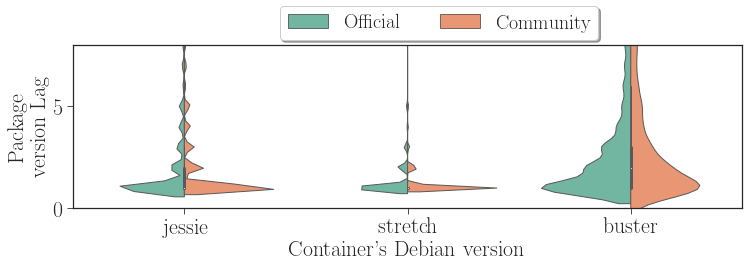

In [82]:
#### For those who are outdated! what is the technical lag

dff=pd.concat([outdate_official,outdate_community]).query('outdate!=0')

order=['jessie','stretch','buster']

ax = sns.violinplot(x="debian", y="outdate", data=dff, hue='type', 
                    palette="Set2", order=order, linewidth=1, split=True)
ax.figure.set_size_inches(12,3)
ax.set_xlabel("Container's Debian version")
ax.set_ylabel('Package \n version Lag')
for patch in ax.patches:
    patch.set_edgecolor('black')
ax.legend(loc='upper right', bbox_to_anchor=(0.8, 1.3), ncol=3, fontsize=20, fancybox=True, shadow=True)

ax.set_ylim(0,8)


In [61]:
print(
    scipy.stats.normaltest(dff.query('debian=="jessie"').outdate),'\n',
    scipy.stats.normaltest(dff.query('debian=="stretch"').outdate),'\n',
    scipy.stats.normaltest(dff.query('debian=="buster"').outdate)
)

NormaltestResult(statistic=199226.59451142949, pvalue=0.0) 
 NormaltestResult(statistic=73249.35985857145, pvalue=0.0) 
 NormaltestResult(statistic=6701.3929051050845, pvalue=0.0)


In [64]:
print(
    scipy.stats.skew(dff.query('debian=="jessie"').outdate),'\n',
    scipy.stats.skew(dff.query('debian=="stretch"').outdate),'\n',
    scipy.stats.skew(dff.query('debian=="buster"').outdate)
)

3.107175484206795 
 7.38030267402652 
 2.104008697147934


In [65]:
print(
    scipy.stats.kurtosis(dff.query('debian=="jessie"').outdate),'\n',
    scipy.stats.kurtosis(dff.query('debian=="stretch"').outdate),'\n',
    scipy.stats.kurtosis(dff.query('debian=="buster"').outdate)
)

14.272852093317322 
 99.1780809367606 
 5.26319859191617


In [66]:
print(
    scipy.stats.kurtosistest(dff.query('debian=="jessie"').outdate),'\n',
    scipy.stats.kurtosistest(dff.query('debian=="stretch"').outdate),'\n',
    scipy.stats.kurtosistest(dff.query('debian=="buster"').outdate)
)

KurtosistestResult(statistic=248.4016262892203, pvalue=0.0) 
 KurtosistestResult(statistic=146.7764507427425, pvalue=0.0) 
 KurtosistestResult(statistic=42.372130197567408, pvalue=0.0)


In [36]:
for x in ['jessie','stretch','buster']:
    print(x,dff.query('debian=="'+x+'" and type=="Official"').outdate.mean(),
          x,dff.query('debian=="'+x+'" and type=="Official"').outdate.median(),'\n',
          x,dff.query('debian=="'+x+'" and type=="Community"').outdate.mean(),
          x,dff.query('debian=="'+x+'" and type=="Community"').outdate.median(),'\n')


jessie 2.137435331165777 jessie 1.0 
 jessie 1.9345266394893634 jessie 1.0 

stretch 1.3682512270496274 stretch 1.0 
 stretch 1.2401006409872402 stretch 1.0 

buster 2.7150595882990247 buster 2.0 
 buster 3.0563760806916425 buster 2.0 



################ It seems that packages are up to date ################
################ Let's check when they were first seen ################

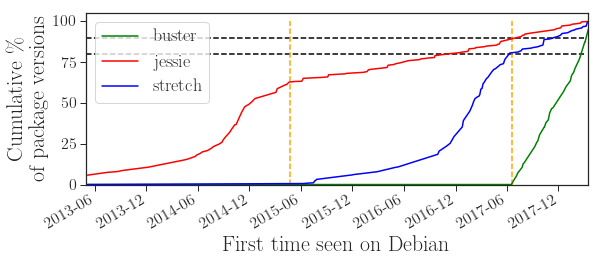

In [406]:
### When UNIQUE package versions that are NOT outdated were first seen
dff=pd.concat([outdate_official,outdate_community])#.query('outdate!=0')

order=['jessie','stretch','buster']

dff=(dff.
 groupby(['package','version','date','release_snapshot']).
 count().
 reset_index().
 groupby(['date','release_snapshot']).
 count().
 loc[:,['package']].
 reset_index())

dff=(dff.
    pivot(index='date', columns='release_snapshot', values='package').
    fillna(0).
    reset_index().
    sort_values('date', ascending=True))

dff['date']=dff['date'].apply(lambda x: datetime.strptime(x, "%Y%m%d"))
dff.set_index('date', inplace=True)

for x in dff:
    dff[x]=dff[x].cumsum()
    max=dff[x].values.max()
    dff[x]=dff[x]*100/max


ax=dff.plot( color=['green','red','blue'])
ax.hlines(80, pd.to_datetime('2013-05-01'), pd.to_datetime('2018-03-01'), colors='black', linestyles='dashed', alpha=1)
ax.hlines(90, pd.to_datetime('2013-05-01'), pd.to_datetime('2018-03-01'), colors='black', linestyles='dashed', alpha=1)

ax.set_ylim(0,)
ax.set_ylabel('Cumulative \% \n of package versions')
ax.set_xlabel('First time seen on Debian')
ax.figure.set_size_inches(9,3.5)
plt.tick_params(axis='both', which='major', labelsize=16, width=1)
L=plt.legend(loc='upper left', prop={'size': 18})
plt.setp(L.texts, family='Consolas')

ax.set_xlim(pd.to_datetime('2013-05-01'), pd.to_datetime('2018-03-17'))

ax.vlines(pd.to_datetime('2015-04-25'), 0,100, colors='orange', linestyles='dashed', alpha=1)
ax.vlines(pd.to_datetime('2017-06-18'), 0,100, colors='orange', linestyles='dashed', alpha=1)
